# Mount Google Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Sanuja Menath\AppData\Roaming\Python\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# Load Data

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

TARGET = "exam_score"


In [3]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

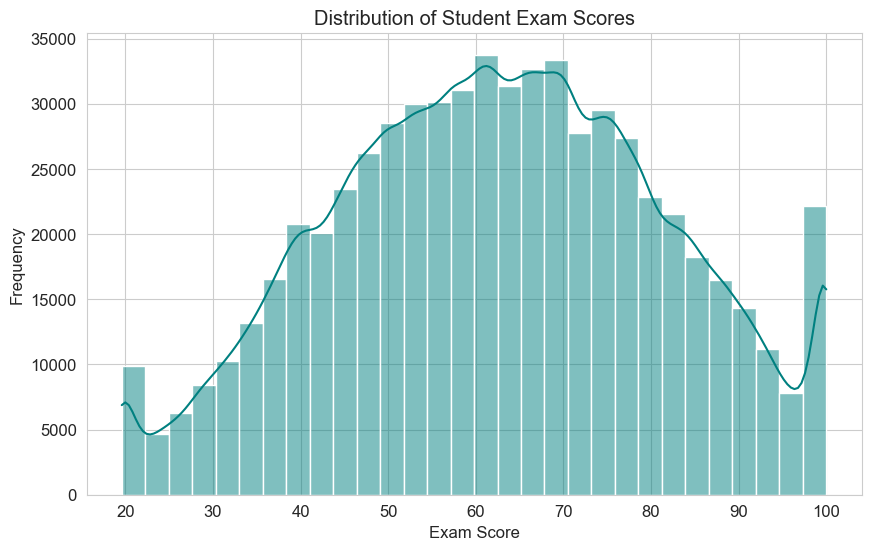

In [4]:
# FIGURE 1: Distribution of Exam Scores
plt.figure(figsize=(10, 6))
sns.histplot(train_df['exam_score'], kde=True, color='teal', bins=30)
plt.title('Distribution of Student Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.savefig('Figure_1_Distribution.png') 
plt.show()

Feature Split

In [5]:
categorical_cols = [
    "gender",
    "course",
    "internet_access",
    "sleep_quality",
    "study_method",
    "facility_rating",
    "exam_difficulty"
]

numerical_cols = [
    "age",
    "study_hours",
    "class_attendance",
    "sleep_hours"
]


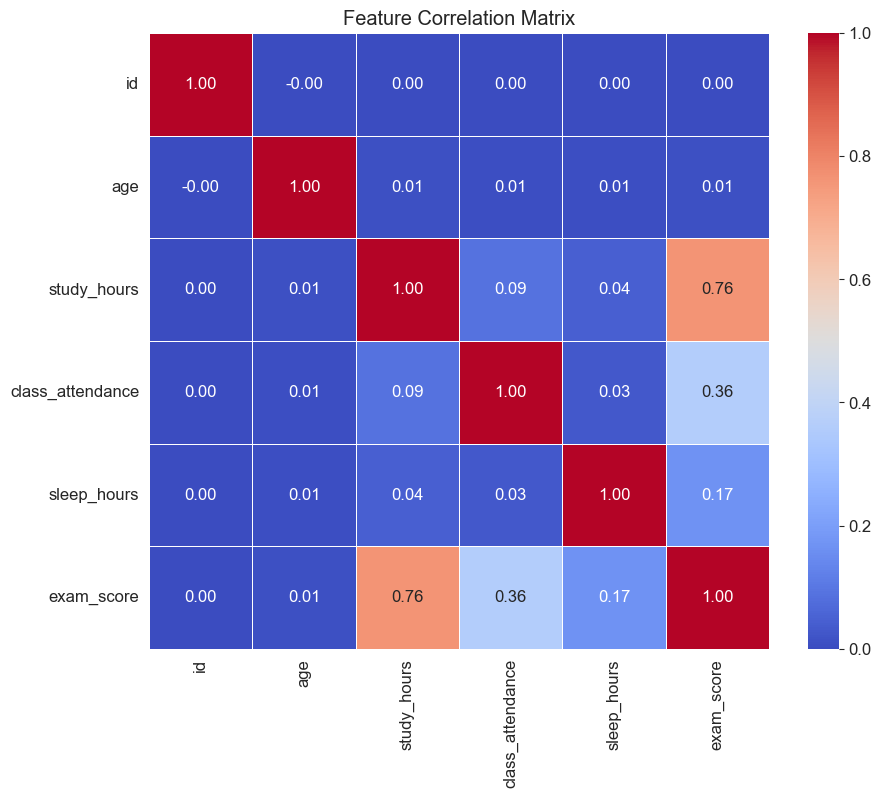

In [6]:
# FIGURE 2: Correlation Heatmap
plt.figure(figsize=(10, 8))
# Selected only numerical columns for correlation
numerical_data = train_df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.savefig('Figure_2_Correlation.png')
plt.show()

Encode Categorical Features

In [7]:
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    encoders[col] = le


C:\Users\Sanuja Menath\AppData\Local\Temp\ipykernel_5800\2768349676.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y='exam_score', data=train_df, palette="Set2")


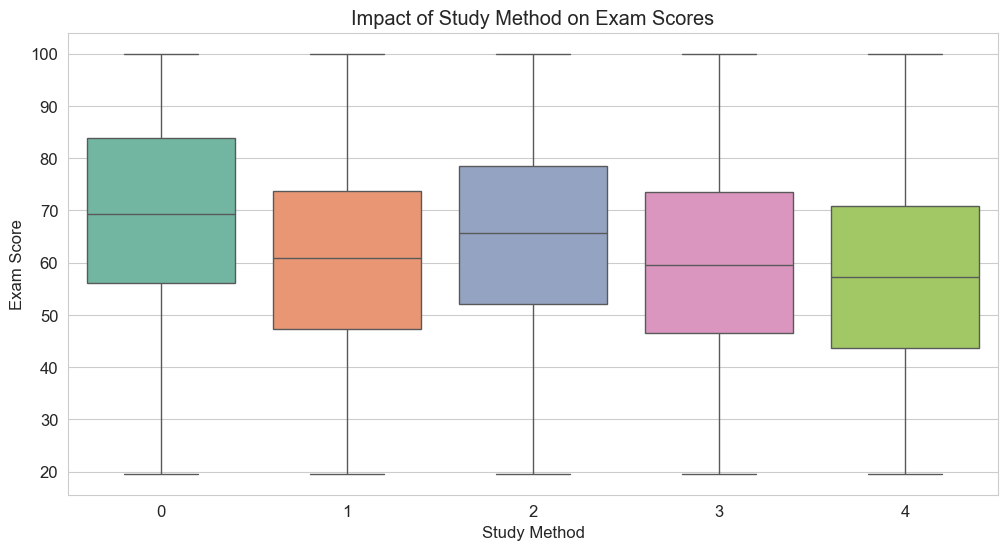

In [8]:
# FIGURE 3: Categorical Box Plot
plt.figure(figsize=(12, 6))
cat_col = 'study_method' if 'study_method' in train_df.columns else 'internet_access'

sns.boxplot(x=cat_col, y='exam_score', data=train_df, palette="Set2")
plt.title(f'Impact of {cat_col.replace("_", " ").title()} on Exam Scores')
plt.xlabel(cat_col.replace("_", " ").title())
plt.ylabel('Exam Score')
plt.savefig('Figure_3_Boxplot.png')
plt.show()

Scale Numerical Features

In [9]:
scaler = StandardScaler()

train_df[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = scaler.transform(test_df[numerical_cols])


Train Validation Split

In [10]:
X = train_df[categorical_cols + numerical_cols]
y = train_df[TARGET]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Build Model

In [11]:
inputs = []
embeddings = []

for col in categorical_cols:
    input_layer = tf.keras.Input(shape=(1,))
    vocab_size = train_df[col].nunique()
    embed_dim = min(50, vocab_size // 2 + 1)

    embed = tf.keras.layers.Embedding(vocab_size, embed_dim)(input_layer)
    embed = tf.keras.layers.Flatten()(embed)

    inputs.append(input_layer)
    embeddings.append(embed)

num_input = tf.keras.Input(shape=(len(numerical_cols),))
inputs.append(num_input)
embeddings.append(num_input)

x = tf.keras.layers.Concatenate()(embeddings)

x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(64, activation="relu")(x)

output = tf.keras.layers.Dense(1, activation="linear")(x)

model = tf.keras.Model(inputs=inputs, outputs=output)


Run Model

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 2)      │          6 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 4)      │         28 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 2)      │          4 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 2)      │          6 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 3)      │         15 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 2)      │          6 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 2)      │          6 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 2)         │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 2)         │          0 │ embedding_3[0][0

 Total params: 48,456 (189.28 KB)

 Trainable params: 47,688 (186.28 KB)

 Non-trainable params: 768 (3.00 KB)

Callbacks

In [13]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=5,
        factor=0.5
    )
]


# Train Model

In [10]:
history = model.fit(
    [X_train[col] for col in categorical_cols] + [X_train[numerical_cols]],
    y_train,
    validation_data=(
        [X_val[col] for col in categorical_cols] + [X_val[numerical_cols]],
        y_val
    ),
    epochs=200,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 235.1725 - root_mean_squared_error: 15.3353 - val_loss: 80.4004 - val_root_mean_squared_error: 8.9666 - learning_rate: 0.0010
Epoch 2/200
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 102.1990 - root_mean_squared_error: 10.1094 - val_loss: 79.1598 - val_root_mean_squared_error: 8.8972 - learning_rate: 0.0010
Epoch 3/200
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 98.4818 - root_mean_squared_error: 9.9238 - val_loss: 79.2489 - val_root_mean_squared_error: 8.9022 - learning_rate: 0.0010
Epoch 4/200
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 94.9273 - root_mean_squared_error: 9.7431 - val_loss: 79.2348 - val_root_mean_squared_error: 8.9014 - learning_rate: 0.0010
Epoch 5/200
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 90.5901 - root_mean_squared_error: 9.5179 - val_loss: 79.0693 - val_root_mean_squared_error: 8.8921 - learning_rate: 0.0010
Epoch 6/200
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step 

# Validation Loss

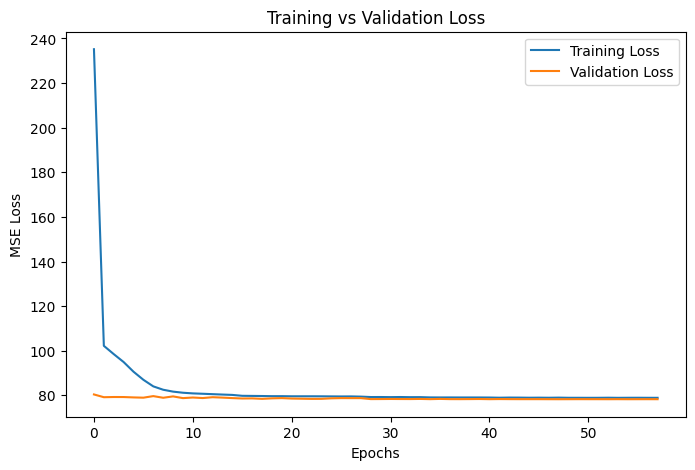

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Submission

In [12]:
test_inputs = [test_df[col] for col in categorical_cols] + [test_df[numerical_cols]]

predictions = model.predict(test_inputs).flatten()

submission = pd.DataFrame({
    "id": test_df["id"],
    "exam_score": predictions
})

submission.to_csv("submission.csv", index=False)


8438/8438 ━━━━━━━━━━━━━━━━━━━━ 8s 948us/step


Save model

In [13]:
model.save("student_score_model.keras")


Save preprocessors

In [14]:
import joblib

joblib.dump(encoders, "label_encoders.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [15]:
def preprocess_input(df):
    for col, le in encoders.items():
        df[col] = le.transform(df[col])
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    return df
